### 1. Importing Libraries and Modules

In [1]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import config as conf

from data.mnist import Mnist
from models.vae import VAE

### 2. Loading MNIST Dataset and Training Results

In [2]:
loader = Mnist()

model_rslt_name = "%s-results.pickle" % conf.MODEL_NAME

model_save_path = os.path.join(conf.MODEL_SAVE_DIR, conf.MODEL_NAME)
model_rslt_path = os.path.join(model_save_path, model_rslt_name)

with open(model_rslt_path, "rb") as f:
    encoder_loss_mean, decoder_loss_mean, loss_mean, gs = pickle.load(f)

### 3. Ploting the Encoder and Decoder Losses

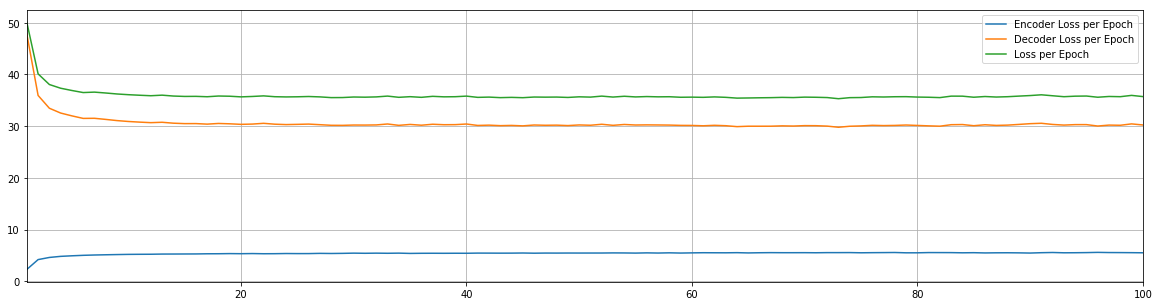

In [3]:
t = np.arange(1, len(encoder_loss_mean)+1)
plt.figure(figsize=[20, 5], facecolor="white")
plt.plot(t, encoder_loss_mean, label="Encoder Loss per Epoch")
plt.plot(t, decoder_loss_mean, label="Decoder Loss per Epoch")
plt.plot(t, loss_mean, label="Loss per Epoch")
plt.xlim(1, 100)
plt.grid()
plt.legend()
plt.show()

### 4. Image Generation Results

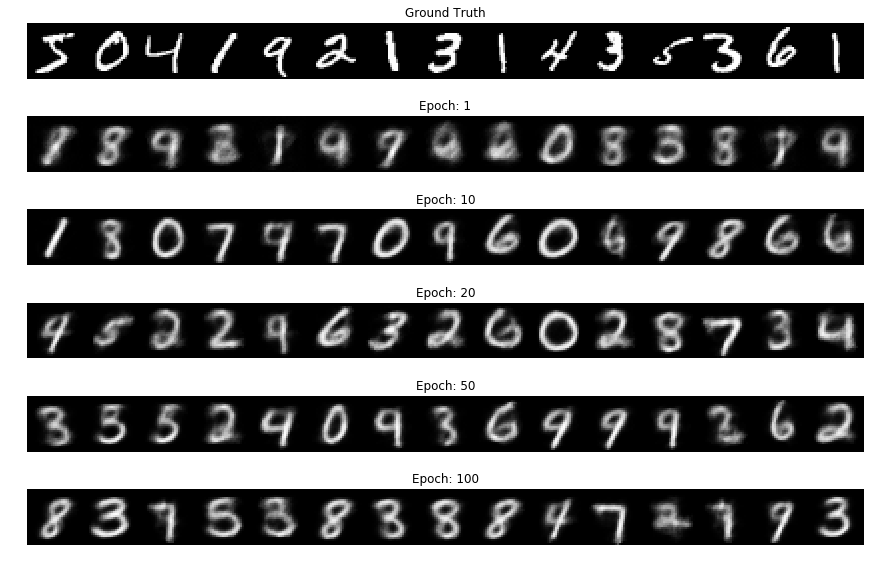

In [4]:
view_list = [1, 10, 20, 50, 100]
view_range = 15 # Should be less than conf.BATCH_SIZE

fig, axs = plt.subplots(nrows=1+len(view_list), figsize=[view_range, 10], facecolor="white")
axs[0].imshow(np.hstack(np.reshape(loader.train_features[:view_range], newshape=[view_range]+loader.feature_shape)), cmap="gray")
axs[0].set_title("Ground Truth")
axs[0].axis("off")

for i, idx in enumerate(view_list, 1):
    g = gs[idx-1]
    axs[i].imshow(np.hstack(np.reshape(g[:view_range], newshape=[view_range]+loader.feature_shape)), cmap="gray")
    axs[i].set_title("Epoch: %i" % idx)
    axs[i].axis("off")
    
plt.savefig(os.path.join(model_save_path, "image_generation_results.png"))

### 5. Loading Ckeckpoint

In [5]:
model_save_path = os.path.join(conf.MODEL_SAVE_DIR, conf.MODEL_NAME)
model_ckpt_path = os.path.join(model_save_path, "model-ckpt")

latent_depth = conf.LATENT_DEPTH
feature_depth = loader.feature_depth

model = VAE(latent_depth, feature_depth)

ckpt = tf.train.Checkpoint(encoder=model.encoder, decoder=model.decoder)

ckpt.restore(tf.train.latest_checkpoint(model_save_path))

### 6. Random Image Generation

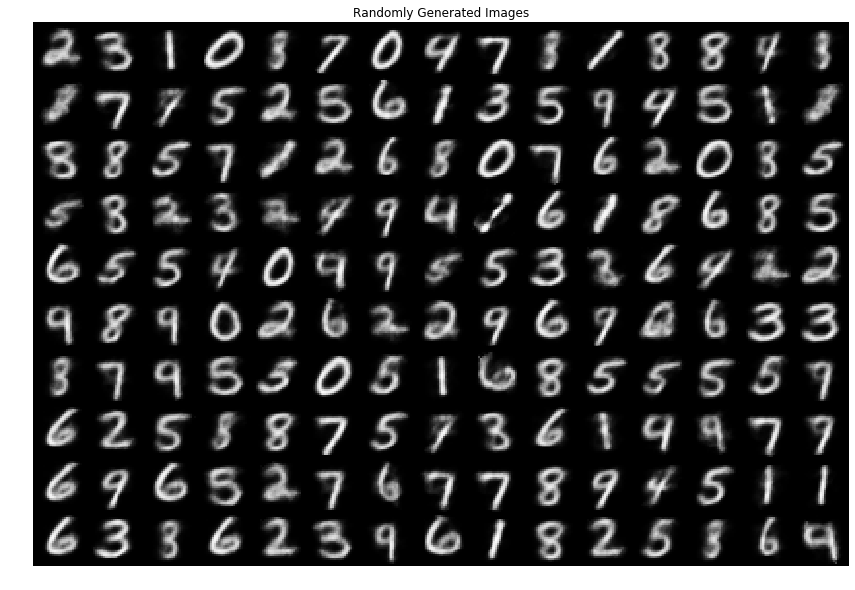

In [6]:
eps = np.random.normal(size=[150, latent_depth]).astype(np.float32)
f = model.decode(eps, training=False)

plt.figure(figsize=[15, 10], facecolor="white")
plt.imshow(np.hstack(np.hstack(np.reshape(f, newshape=[10, 15]+loader.feature_shape))), cmap="gray")
plt.axis("off")
plt.title("Randomly Generated Images")

plt.savefig(os.path.join(model_save_path, "randomly_generated_images.png"))

### 7. Plotting the Latent Distribution

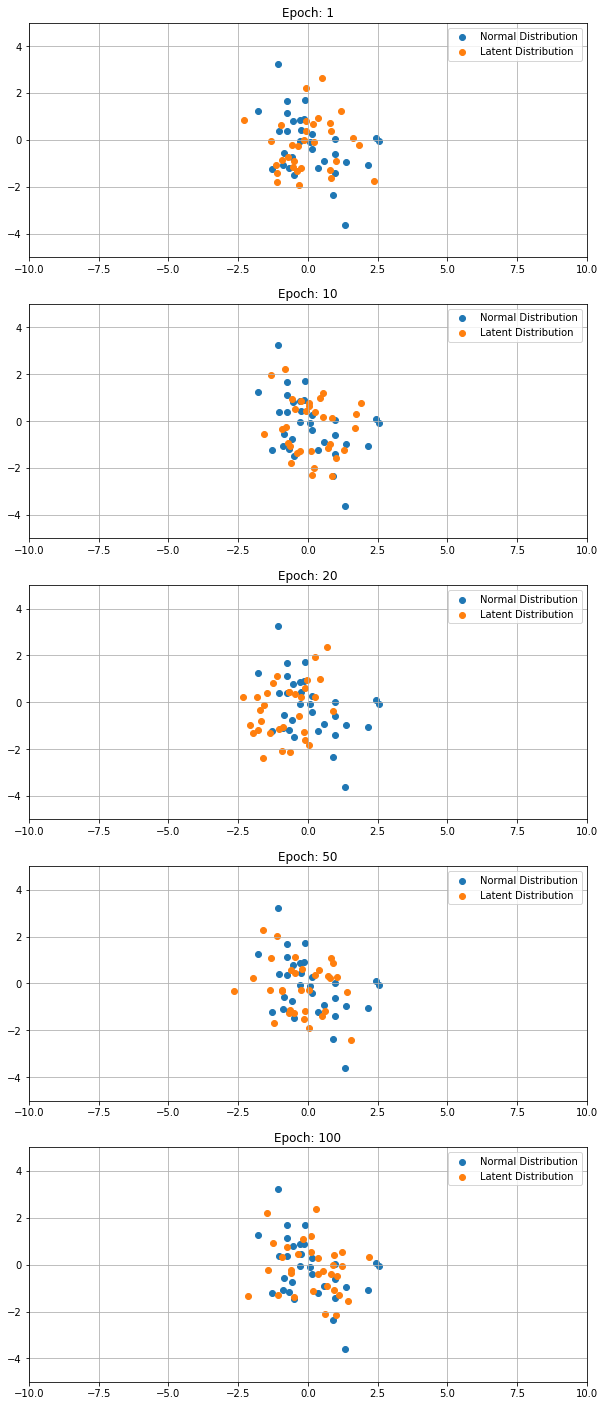

In [31]:
num_points = 32
view_list = [1, 10, 20, 50, 100]

eps = np.random.normal(size=[num_points, latent_depth]).astype(np.float32)

fig, axs = plt.subplots(nrows=len(view_list), figsize=[10, 5*len(view_list)], facecolor="white")
for i, idx in enumerate(view_list):
    model_ckpt_path = os.path.join(model_save_path, "model-ckpt-%i" % idx)
    ckpt.restore(model_ckpt_path)

    mu, log_sigma = model.encode(loader.train_features[:num_points], training=False)
    z = np.random.normal(size=[num_points, latent_depth]).astype(np.float32)
    z = model.reparam(z, mu, log_sigma)

    axs[i].scatter(eps[:, 0], eps[:, 1], label="Normal Distribution")
    axs[i].scatter(z[:, 0], z[:, 1], label="Latent Distribution")
    
    axs[i].grid()
    axs[i].legend()
    axs[i].set_title("Epoch: %i" % idx)
    axs[i].set_xlim(-10, 10)
    axs[i].set_ylim(-5, 5)
    
plt.savefig(os.path.join(model_save_path, "latent_distribution_results.png"))